In [1]:
import sys
import os, glob
import pandas as pd 
from tqdm import tqdm
import time
sys.path.append('..')
from astropy.io import fits
from scipy.optimize import curve_fit, leastsq
from inverse_problem.milne_edington.me import HinodeME, BatchHinodeME
from inverse_problem import me_model
from inverse_problem.nn_inversion.lm_inversion import NlInversion, lm_inversion, inverse_one_line
from inverse_problem.nn_inversion.posthoc import real_spectra, open_spectrum_data, open_param_file, plot_model_spectrum
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Анализ устойчивости решения обратной задачи 
(нелинейный МНК)


### Загружаем данные для спектров и для параметров

In [2]:
path_to_refer = '../data/hinode_source/20140926_170005.fits'
sp_folder = os.path.join("../data/hinode_source/", 'sp_20140926_170005')

In [3]:
nl_mls = NlInversion(path_to_refer, sp_folder) 

Real spectrum for parameters
Field_Strength: 86.25, Field_Inclination: 100.85, Field_Azimuth: 173.33, Doppler_Width: 33.48, Damping: 0.05, Line_Strength: 32.83, Source_Function: 3767.85, Source_Function_Gradient: 33184.72, Doppler_Shift2: -1.65, Stray_Light_Fill_Factor: 0.19, Stray_Light_Shift: -0.55


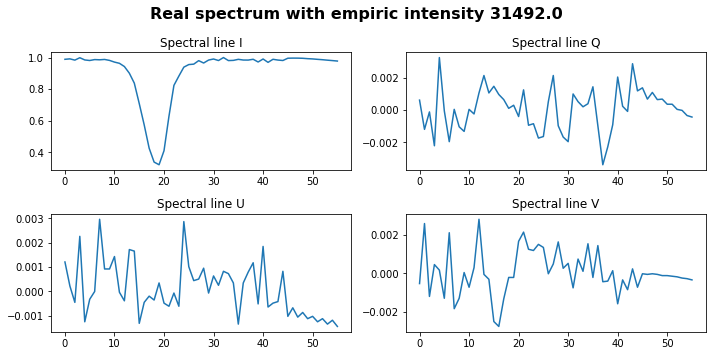

In [4]:
idx_0 = 10
idx_1 = 100
real_line, cont_int, param_vec_raw = nl_mls.get_real_spectrum(idx_0, idx_1, plot_spectrum = True, norm=True)

Model spectrum for parameters
Field_Strength: 86.25, Field_Inclination: 100.85, Field_Azimuth: 173.33, Doppler_Width: 33.48, Damping: 0.05, Line_Strength: 32.83, Source_Function: 3767.85, Source_Function_Gradient: 33184.72, Doppler_Shift2: -1.65, Stray_Light_Fill_Factor: 0.19, Stray_Light_Shift: -0.55


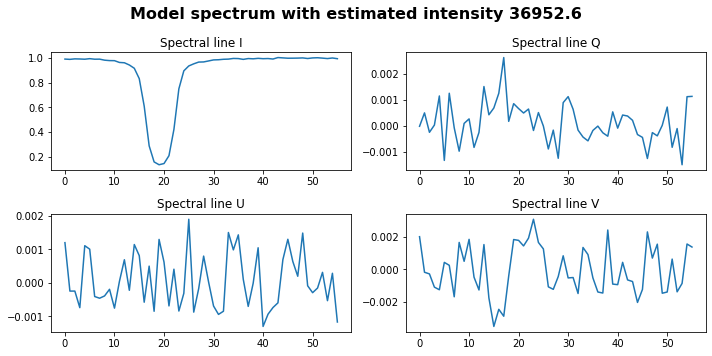

In [10]:
model_line, param_vec_norm, cont = nl_mls.get_model_spectrum(idx_0, idx_1, norm = True, plot_spectrum = True)

Model spectrum for parameters
Field_Strength: 86.25, Field_Inclination: 100.85, Field_Azimuth: 173.33, Doppler_Width: 33.48, Damping: 0.05, Line_Strength: 32.83, Source_Function: 3767.85, Source_Function_Gradient: 33184.72, Doppler_Shift2: -1.65, Stray_Light_Fill_Factor: 0.19, Stray_Light_Shift: -0.55


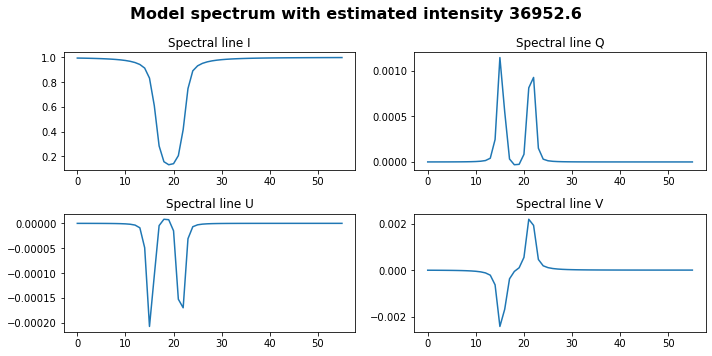

In [11]:
model_line, param_vec_norm, cont = nl_mls.get_model_spectrum(idx_0, idx_1, norm = True, plot_spectrum = True, with_noise=False)

In [ ]:
model_line, param_vec_norm, cont = nl_mls.get_model_spectrum(idx_0, idx_1, norm = True, plot_spectrum = True)

##  Инверсия реального спектра
отсюда и так видно что рандомный старт очень нестабилен

In [6]:
df = nl_mls.inv_line_compare_inits(real_line, param_vec_norm, n_iter=50, lm=False)
df.round(2)

100%|███████████████████████████████████████████| 50/50 [01:14<00:00,  1.50s/it]


,target,pred(init:mean),err(init:mean),pred(init:true),err(init:true),mean_pred(init:random),std_pred(init:random),mean_err(init:random)
0,86.25,461.88,74.07,457.45,74.19,1343.96,1747.36,2.539100e+02
1,100.85,91.55,2.97,91.59,2.95,89.53,36.94,7.931800e+06
2,173.33,8.82,5.98,180.00,5.96,76.20,79.32,1.171242e+09
3,33.48,30.87,1.92,30.73,1.92,31.94,9.29,1.820000e+00
4,0.05,0.29,0.05,0.29,0.05,0.33,0.06,4.000000e-02
5,32.83,7.86,2.69,8.06,2.82,7.16,2.43,2.210000e+00
6,0.10,0.14,38626.10,0.17,32503.34,0.10,0.09,1.588435e+04
7,0.90,0.69,187092.76,0.80,153430.21,0.77,0.27,8.761572e+04
8,-1.65,-2.91,0.15,-2.90,0.14,-0.89,4.44,4.200000e-01
9,0.19,0.29,0.05,0.29,0.05,0.30,0.21,3.000000e-02


## Инверсия модельного спектра

для модельного спектра есть еще аспект генерации шумов, здесь для каждого типа начальных данных смотрим как для одних и тех же параметров варьируется история с шумами

In [7]:
nl_mls.inv_compare_model_noise(param_vec_raw, n_iter=50, initial="random")

100%|███████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


,target,mean_predicted,std_predicted,mean_pred_unc
0,86.247986,896.006994,1587.513886,3.011975e+02
1,100.847435,99.586878,45.006968,1.717370e+06
2,173.327591,85.550813,77.268582,1.782273e+07
3,33.476330,34.404979,3.096423,5.509084e-01
4,0.052712,0.060716,0.025923,4.589440e-03
5,32.826553,32.265903,13.955346,5.273001e+00
6,3767.845459,0.097311,0.035116,4.426673e+03
7,33184.718750,0.851498,0.175871,4.135898e+04
8,-1.651181,-0.713868,4.086072,3.826441e-01
9,0.192772,0.226489,0.239223,3.351207e-02


In [8]:
nl_mls.inv_compare_model_noise(param_vec_raw, n_iter=5, initial="emp_mean")

100%|███████████████████████████████████████████| 50/50 [00:16<00:00,  2.97it/s]


,target,mean_predicted,std_predicted,mean_pred_unc
0,86.247986,86.691682,52.990723,4.153706e+01
1,100.847435,106.121185,17.330574,6.989935e+05
2,173.327591,107.133930,73.345250,3.053502e+07
3,33.476330,32.962083,1.238281,7.017952e-01
4,0.052712,0.048601,0.010246,5.733290e-03
5,32.826553,39.951875,14.713849,7.779530e+00
6,3767.845459,0.103789,0.018541,4.706840e+03
7,33184.718750,0.883510,0.125089,4.008942e+04
8,-1.651181,-1.612489,0.397814,8.893258e-02
9,0.192772,0.245687,0.162663,4.125618e-02


In [9]:
nl_mls.inv_compare_model_noise(param_vec_raw, n_iter=50, initial="true")

100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.67it/s]


,target,mean_predicted,std_predicted,mean_pred_unc
0,86.247986,92.187928,44.943896,5.076734e+01
1,100.847435,106.276525,17.037175,3.870425e+04
2,173.327591,169.785540,10.435758,1.049259e+06
3,33.476330,33.145933,1.411424,6.704475e-01
4,0.052712,0.050319,0.011050,5.519137e-03
5,32.826553,38.811199,16.573634,7.434970e+00
6,3767.845459,0.101186,0.013052,4.730366e+03
7,33184.718750,0.879447,0.061184,4.113615e+04
8,-1.651181,-1.776121,0.302953,1.025961e-01
9,0.192772,0.193375,0.082210,3.961364e-02
